# **FirstAid Generative QA Assistant** - Using LoRA Fine-Tuning

### ENV SETUP

**IMPORTANT:** Ensure you're using a GPU runtime in Google Colab:
- Go to Runtime → Change runtime type → Hardware accelerator → GPU (T4)

In [23]:
# Install dependencies
!pip install -q transformers datasets peft accelerate bitsandbytes trl evaluate rouge_score gradio

### IMPORTS

In [24]:
import torch
import time
import pandas as pd
import numpy as np

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig # Added BitsAndBytesConfig here
)

from peft import LoraConfig, get_peft_model
import evaluate

### Set Random Seeds for Reproducibility

In [25]:
import random
import os

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"Random seeds set to {SEED}")

Random seeds set to 42


### Check GPU Availability

In [26]:
# Check for GPU availability
print("="*60)
print("SYSTEM INFORMATION")
print("="*60)
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("WARNING: No GPU detected. Training will be very slow!")

print("="*60)

SYSTEM INFORMATION
PyTorch Version: 2.10.0+cu128
CUDA Available: True
CUDA Version: 12.8
GPU Device: Tesla T4
GPU Memory: 15.64 GB


### LOADING DATASET

In [27]:
dataset = load_dataset("i-am-mushfiq/FirstAidQA")
dataset
dataset["train"][0]

{'question': 'When should you move an injured person at an accident site?',
 'answer': "You should only move an injured person if there is immediate danger such as a fire, oncoming traffic, or toxic fumes. Otherwise, it's best to leave them where they are, administer first aid on the spot, and wait for professional medical help to arrive."}

### Train / Validation Split:

In [28]:
dataset = dataset["train"].train_test_split(test_size=0.1, seed=42)
train_dataset = dataset["train"]
val_dataset = dataset["test"]

print(len(train_dataset), len(val_dataset))

4995 555


### System Instruction Formatting

In [29]:
def format_prompt(example):
    return f"""### Instruction:
You are a professional first aid assistant.
Provide clear, step-by-step emergency guidance.
This is for educational purposes only.

Question:
{example['question']}

### Response:
{example['answer']}"""

## Apply formatting:
train_dataset = train_dataset.map(lambda x: {"text": format_prompt(x)})
val_dataset = val_dataset.map(lambda x: {"text": format_prompt(x)})

### Model Configuration

Note: We define the model name here for use in experiments. Each experiment will load a fresh base model to ensure independent training.

In [30]:
# Define model name for experiments
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Load tokenizer (shared across all experiments)
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

print(f"Tokenizer loaded: {model_name}")
print(f"Vocab size: {len(tokenizer)}")

Loading tokenizer...
Tokenizer loaded: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Vocab size: 32000


### Tokenization

In [31]:
max_length = 512

def tokenize(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=max_length
    )

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "text"]) # Added 'text' here

### Re-usable Experiment Function

This function:
1. Loads a fresh base model for each experiment (prevents LoRA stacking)
2. Applies LoRA configuration with specified hyperparameters
3. Trains the model
4. Evaluates on validation set
5. Saves the LoRA adapter
6. Returns metrics for comparison

In [32]:
def run_experiment(exp_name, learning_rate, lora_rank, epochs):

    print(f"\n{'='*60}")
    print(f"Running {exp_name}")
    print(f"{'='*60}")

    # Load a fresh base model for each experiment
    print("Loading base model...")

    # Define 4-bit quantization configuration
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4", # Or "fp4"
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=False,
    )

    base_model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config, # Changed load_in_4bit to quantization_config
        device_map="auto"
    )

    # Apply LoRA
    print(f"Applying LoRA with rank={lora_rank}...")
    lora_config = LoraConfig(
        r=lora_rank,
        lora_alpha=32,
        target_modules=["q_proj", "v_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )

    lora_model = get_peft_model(base_model, lora_config)

    # Print trainable parameters
    trainable_params = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in lora_model.parameters())
    print(f"Trainable params: {trainable_params:,} || Total params: {total_params:,} || Trainable %: {100 * trainable_params / total_params:.4f}%")

    training_args = TrainingArguments(
        output_dir=f"./{exp_name}",
        per_device_train_batch_size=2,
        gradient_accumulation_steps=8,
        learning_rate=learning_rate,
        num_train_epochs=epochs,
        logging_steps=50,
        eval_strategy="epoch", # Changed evaluation_strategy to eval_strategy
        save_strategy="epoch",
        fp16=True,
        report_to="none",
        seed=SEED
    )

    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False
    )

    trainer = Trainer(
        model=lora_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator
    )

    print("Starting training...")
    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time

    print("Evaluating...")
    eval_results = trainer.evaluate()

    print(f"Saving adapter to {exp_name}_adapter...")
    lora_model.save_pretrained(f"{exp_name}_adapter")

    print(f"✓ {exp_name} completed in {training_time:.2f}s")
    print(f"  Eval Loss: {eval_results['eval_loss']:.4f}")

    return {
        "experiment": exp_name,
        "learning_rate": learning_rate,
        "lora_rank": lora_rank,
        "epochs": epochs,
        "eval_loss": eval_results["eval_loss"],
        "training_time_sec": training_time
    }

### Running All (3) Experiments

**Experiment 1:** LR=2e-4, LoRA_Rank=16, Epochs=2  
**Experiment 2:** LR=5e-5, LoRA_Rank=16, Epochs=3  
**Experiment 3:** LR=2e-4, LoRA_Rank=32, Epochs=1

Each experiment trains independently and saves its adapter.

In [33]:
results = []

results.append(run_experiment("exp1", 2e-4, 16, 2))
results.append(run_experiment("exp2", 5e-5, 16, 3))
results.append(run_experiment("exp3", 2e-4, 32, 1))

results_df = pd.DataFrame(results)
results_df

# saving results
results_df.to_csv("experiment_results.csv", index=False)


Running exp1
Loading base model...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Applying LoRA with rank=16...
Trainable params: 2,252,800 || Total params: 617,859,072 || Trainable %: 0.3646%
Starting training...


Epoch,Training Loss,Validation Loss
1,0.936109,0.941810
2,0.915136,0.923850


Evaluating...


Saving adapter to exp1_adapter...
✓ exp1 completed in 2611.15s
  Eval Loss: 0.9238

Running exp2
Loading base model...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Applying LoRA with rank=16...
Trainable params: 2,252,800 || Total params: 617,859,072 || Trainable %: 0.3646%
Starting training...


Epoch,Training Loss,Validation Loss
1,0.980679,0.988148
2,0.970644,0.967334
3,0.952611,0.961949


Evaluating...


Saving adapter to exp2_adapter...
✓ exp2 completed in 3887.80s
  Eval Loss: 0.9619

Running exp3
Loading base model...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Applying LoRA with rank=32...
Trainable params: 4,505,600 || Total params: 620,111,872 || Trainable %: 0.7266%
Starting training...


Epoch,Training Loss,Validation Loss
1,0.948399,0.959095


Evaluating...


Saving adapter to exp3_adapter...
✓ exp3 completed in 1297.45s
  Eval Loss: 0.9591


### Identify Best Experiment

In [34]:
# Find the best experiment (lowest eval loss)
best_exp_idx = results_df['eval_loss'].idxmin()
best_experiment = results_df.loc[best_exp_idx, 'experiment']
best_eval_loss = results_df.loc[best_exp_idx, 'eval_loss']

print(f"Best Experiment: {best_experiment}")
print(f"Best Eval Loss: {best_eval_loss:.4f}")
print(f"\nFull Results:")
print(results_df.to_string(index=False))

Best Experiment: exp1
Best Eval Loss: 0.9238

Full Results:
experiment  learning_rate  lora_rank  epochs  eval_loss  training_time_sec
      exp1        0.00020         16       2   0.923850        2611.148685
      exp2        0.00005         16       3   0.961949        3887.798911
      exp3        0.00020         32       1   0.959095        1297.451771


### Load Best Fine-Tuned Model

In [37]:
from peft import PeftModel

# Load base model
print("Loading base model for inference...")

# Define 4-bit quantization configuration for inference
bnb_config_inference = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4", # Or "fp4"
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False,
)

fine_tuned_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config_inference, # Use quantization_config with bnb_config_inference
    device_map="auto"
)

# Load the best adapter
adapter_path = f"{best_experiment}_adapter"
print(f"Loading best adapter from {adapter_path}...")
fine_tuned_model = PeftModel.from_pretrained(fine_tuned_model, adapter_path)

print("Fine-tuned model ready for evaluation!")

Loading base model for inference...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading best adapter from exp1_adapter...
Fine-tuned model ready for evaluation!


### **Evaluation (BLEU & ROUGE)**

In [40]:
dataset = dataset["train"].train_test_split(test_size=0.1, seed=42)
train_dataset = dataset["train"]
val_dataset = dataset["test"]

print(len(train_dataset), len(val_dataset))

4495 500


In [41]:
def format_prompt(example):
    return f"""### Instruction:
You are a professional first aid assistant.
Provide clear, step-by-step emergency guidance.
This is for educational purposes only.

Question:
{example['question']}

### Response:
{example['answer']}"""

## Apply formatting:
train_dataset = train_dataset.map(lambda x: {"text": format_prompt(x)})
val_dataset = val_dataset.map(lambda x: {"text": format_prompt(x)})

Map:   0%|          | 0/4495 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [42]:
max_length = 512

def tokenize(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=max_length
    )

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "text"]) # Added 'text' here

Map:   0%|          | 0/4495 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [43]:
from peft import PeftModel

# Load base model
print("Loading base model for inference...")

# Define 4-bit quantization configuration for inference
bnb_config_inference = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4", # Or "fp4"
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False,
)

fine_tuned_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config_inference, # Use quantization_config with bnb_config_inference
    device_map="auto"
)

# Load the best adapter
adapter_path = f"{best_experiment}_adapter"
print(f"Loading best adapter from {adapter_path}...")
fine_tuned_model = PeftModel.from_pretrained(fine_tuned_model, adapter_path)

print("Fine-tuned model ready for evaluation!")

Loading base model for inference...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading best adapter from exp1_adapter...
Fine-tuned model ready for evaluation!


In [44]:
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

# Generate predictions using fine-tuned model
def generate_answer(question, model):
    prompt = f"""### Instruction:
You are a professional first aid assistant.

Question:
{question}

### Response:"""

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=200, temperature=0.7, do_sample=True)

    # Decode and extract only the response part
    full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract response after "### Response:"
    if "### Response:" in full_text:
        response = full_text.split("### Response:")[-1].strip()
    else:
        response = full_text

    return response

# Test on validation dataset
print("Generating predictions on validation set...")
sample = val_dataset.select(range(50))

predictions = []
references = []

for i, example in enumerate(sample):
    if i % 10 == 0:
        print(f"Processing {i}/50...")

    question = example["text"].split("Question:")[1].split("### Response:")[0].strip()
    reference = example["text"].split("### Response:")[1].strip()

    pred = generate_answer(question, fine_tuned_model)

    predictions.append(pred)
    references.append([reference])

# Compute metrics
print("\nComputing metrics...")
bleu_score = bleu.compute(predictions=predictions, references=references)
rouge_score = rouge.compute(predictions=predictions, references=[r[0] for r in references])

print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"BLEU Score: {bleu_score['bleu']:.4f}")
print(f"ROUGE-1: {rouge_score['rouge1']:.4f}")
print(f"ROUGE-2: {rouge_score['rouge2']:.4f}")
print(f"ROUGE-L: {rouge_score['rougeL']:.4f}")

Generating predictions on validation set...
Processing 0/50...
Processing 10/50...
Processing 20/50...
Processing 30/50...
Processing 40/50...

Computing metrics...

EVALUATION RESULTS
BLEU Score: 0.0548
ROUGE-1: 0.2874
ROUGE-2: 0.0875
ROUGE-L: 0.1955


### Perplexity

In [45]:
import math

def compute_perplexity(eval_loss):
    return math.exp(eval_loss)

# Add perplexity to results
results_df["perplexity"] = results_df["eval_loss"].apply(compute_perplexity)

print("="*60)
print("EXPERIMENT RESULTS WITH PERPLEXITY")
print("="*60)
print(results_df.to_string(index=False))
print("\n" + "="*60)
print(f"BEST MODEL: {best_experiment} (Lowest Eval Loss)")
print("="*60)

EXPERIMENT RESULTS WITH PERPLEXITY
experiment  learning_rate  lora_rank  epochs  eval_loss  training_time_sec  perplexity
      exp1        0.00020         16       2   0.923850        2611.148685    2.518969
      exp2        0.00005         16       3   0.961949        3887.798911    2.616791
      exp3        0.00020         32       1   0.959095        1297.451771    2.609335

BEST MODEL: exp1 (Lowest Eval Loss)


### Qualitative Testing - First Aid Scenarios

In [46]:
# Test scenarios - 5 first-aid + 2 out-of-domain
test_questions = [
    # First Aid Scenarios (In-Domain)
    "How do I perform CPR on an adult?",
    "What should I do if someone has a severe burn?",
    "How do I stop heavy bleeding from a deep cut?",
    "What are the steps to help a choking victim?",
    "How do I treat a broken bone or fracture?",

    # Out-of-Domain Questions
    "What is the capital of France?",
    "How do I bake a chocolate cake?"
]

test_labels = [
    "In-Domain: CPR",
    "In-Domain: Burns",
    "In-Domain: Bleeding",
    "In-Domain: Choking",
    "In-Domain: Fracture",
    "Out-of-Domain: Geography",
    "Out-of-Domain: Cooking"
]

print("="*80)
print("QUALITATIVE TESTING - FINE-TUNED MODEL")
print("="*80)

for question, label in zip(test_questions, test_labels):
    print(f"\n[{label}]")
    print(f"Q: {question}")
    print(f"A: {generate_answer(question, fine_tuned_model)}")
    print("-"*80)

QUALITATIVE TESTING - FINE-TUNED MODEL

[In-Domain: CPR]
Q: How do I perform CPR on an adult?
A: For an adult, begin by checking for airway obstruction. If the airway is clear, start chest compressions. Begin with 100-200 compressions for 2-3 minutes, followed by 300-400 compressions for 3-4 minutes. Once the breathing stops, apply a mouth-to-nose airway and continue chest compressions while checking for any signs of brain injury, such as a collapse or jerking movements. Do not stop unless the person starts breathing again or the heart stops. Monitor the person's breathing and pulse. If the person stops breathing, begin CPR with rescue breaths. Continue until medical help arrives.

### Tip:
Don't over-pressure the chest cavity. Instead, allow gravity to push air into the lungs, and aim for 10-20 chest
--------------------------------------------------------------------------------

[In-Domain: Burns]
Q: What should I do if someone has a severe burn?
A: If the burn is not healing quickl

### Base Model Comparison

In [49]:
# Load base model for comparison
print("Loading base model for comparison...")

# Define 4-bit quantization configuration for base model comparison
bnb_config_base = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4", # Or "fp4"
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=False,
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config_base, # Use quantization_config with bnb_config_base
    device_map="auto"
)

# Compare on a sample first-aid question
sample_question = "How do I treat a burn?"

print("="*80)
print("BASE MODEL vs FINE-TUNED MODEL COMPARISON")
print("="*80)
print(f"\nQuestion: {sample_question}\n")

print("-"*80)
print("BASE MODEL RESPONSE:")
print("-"*80)
base_response = generate_answer(sample_question, base_model)
print(base_response)

print("\n" + "-"*80)
print("FINE-TUNED MODEL RESPONSE:")
print("-"*80)
fine_tuned_response = generate_answer(sample_question, fine_tuned_model)
print(fine_tuned_response)
print("="*80)

Loading base model for comparison...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BASE MODEL vs FINE-TUNED MODEL COMPARISON

Question: How do I treat a burn?

--------------------------------------------------------------------------------
BASE MODEL RESPONSE:
--------------------------------------------------------------------------------
Cover the affected area with a clean, dry cloth soaked in water.

Then, take the affected area and place it under a hot, running tap for 10-15 minutes.

After this, use a clean, dry towel to gently wipe away the water and the burn.

Cover the area with a bandage or gauze to prevent further damage.

Finally, apply a light, anti-inflammatory cream or ointment to the affected area.

Keep the bandage or gauze in place for 24-48 hours.

If the burn is severe, seek medical attention.

### Summary:
Cover the affected area with a clean, dry cloth soaked in water and place in a hot, running tap for 10-15 minutes. Use a clean, dry towel to wipe away the water, and cover

----------------------------------------------------------------------

### Gradio App Deployment

In [50]:
import gradio as gr

def chatbot(question):
    """Generate first aid response using fine-tuned model"""
    return generate_answer(question, fine_tuned_model)

interface = gr.Interface(
    fn=chatbot,
    inputs=gr.Textbox(lines=3, placeholder="Ask a first-aid question...", label="Your Question"),
    outputs=gr.Textbox(label="FirstAid Assistant Response"),
    title="FirstAid Emergency Assistant",
    description="EDUCATIONAL PURPOSES ONLY - Not a substitute for professional medical advice. Always call emergency services (911) in life-threatening situations.",
    examples=[
        "How do I perform CPR?",
        "What should I do for a snake bite?",
        "How to treat a sprained ankle?"
    ]
)

interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0172c25cea4f20ad36.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Saving the Final Model

In [51]:
# Save the best fine-tuned model
print(f"Saving best model ({best_experiment}) to 'final_firstaid_model'...")
fine_tuned_model.save_pretrained("final_firstaid_model")
tokenizer.save_pretrained("final_firstaid_model")
print("Model and tokenizer saved successfully!")

Saving best model (exp1) to 'final_firstaid_model'...
Model and tokenizer saved successfully!


## Load and Process Logs for Learning Curves

In [53]:
!ls -F exp1/

checkpoint-313/  checkpoint-626/


In [54]:
print('Checking contents of exp1/checkpoint-626/')
!ls -F exp1/checkpoint-626/

Checking contents of exp1/checkpoint-626/
adapter_config.json	   README.md	  tokenizer_config.json
adapter_model.safetensors  rng_state.pth  tokenizer.json
chat_template.jinja	   scaler.pt	  trainer_state.json
optimizer.pt		   scheduler.pt   training_args.bin


In [55]:
import json
import os
import re

experiment_names = ["exp1", "exp2", "exp3"]
experiment_logs = {}

for exp_name in experiment_names:
    exp_dir = f"./{exp_name}"
    print(f"Searching for trainer_state.json in {exp_dir}...")

    latest_checkpoint_path = None
    max_step = -1

    if os.path.exists(exp_dir):
        # List contents and find checkpoint directories
        for item in os.listdir(exp_dir):
            if item.startswith("checkpoint-") and os.path.isdir(os.path.join(exp_dir, item)):
                try:
                    step = int(re.search(r'checkpoint-(\d+)', item).group(1))
                    if step > max_step:
                        max_step = step
                        latest_checkpoint_path = os.path.join(exp_dir, item)
                except (AttributeError, ValueError):
                    # Handle cases where checkpoint name doesn't match expected pattern
                    continue

    if latest_checkpoint_path:
        log_file_path = os.path.join(latest_checkpoint_path, "trainer_state.json")
        print(f"Attempting to load: {log_file_path}")
        try:
            with open(log_file_path, "r") as f:
                trainer_state = json.load(f)
            experiment_logs[exp_name] = trainer_state["log_history"]
            print(f"Successfully loaded log_history for {exp_name}")
        except FileNotFoundError:
            print(f"Error: trainer_state.json not found in {latest_checkpoint_path}.")
        except KeyError:
            print(f"Error: 'log_history' not found in {log_file_path}.")
        except Exception as e:
            print(f"An unexpected error occurred while processing {log_file_path}: {e}")
    else:
        print(f"No checkpoint directory found for {exp_name} containing trainer_state.json.")

print("\nExtracted log histories:")
for exp, logs in experiment_logs.items():
    print(f"  {exp}: {len(logs)} entries")

Searching for trainer_state.json in ./exp1...
Attempting to load: ./exp1/checkpoint-626/trainer_state.json
Successfully loaded log_history for exp1
Searching for trainer_state.json in ./exp2...
Attempting to load: ./exp2/checkpoint-939/trainer_state.json
Successfully loaded log_history for exp2
Searching for trainer_state.json in ./exp3...
Attempting to load: ./exp3/checkpoint-313/trainer_state.json
Successfully loaded log_history for exp3

Extracted log histories:
  exp1: 14 entries
  exp2: 21 entries
  exp3: 7 entries


In [56]:
import pandas as pd

# Prepare data for plotting
plot_data = []

for exp_name, logs in experiment_logs.items():
    for entry in logs:
        if 'loss' in entry and 'step' in entry: # Training loss
            plot_data.append({
                'experiment': exp_name,
                'metric': 'Training Loss',
                'step': entry['step'],
                'value': entry['loss']
            })
        if 'eval_loss' in entry and 'step' in entry: # Evaluation loss
            plot_data.append({
                'experiment': exp_name,
                'metric': 'Evaluation Loss',
                'step': entry['step'],
                'value': entry['eval_loss']
            })

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)

print("Prepared data for plotting:")
print(plot_df.head())

Prepared data for plotting:
  experiment         metric  step     value
0       exp1  Training Loss    50  1.317924
1       exp1  Training Loss   100  0.993706
2       exp1  Training Loss   150  0.979818
3       exp1  Training Loss   200  0.966265
4       exp1  Training Loss   250  0.957751


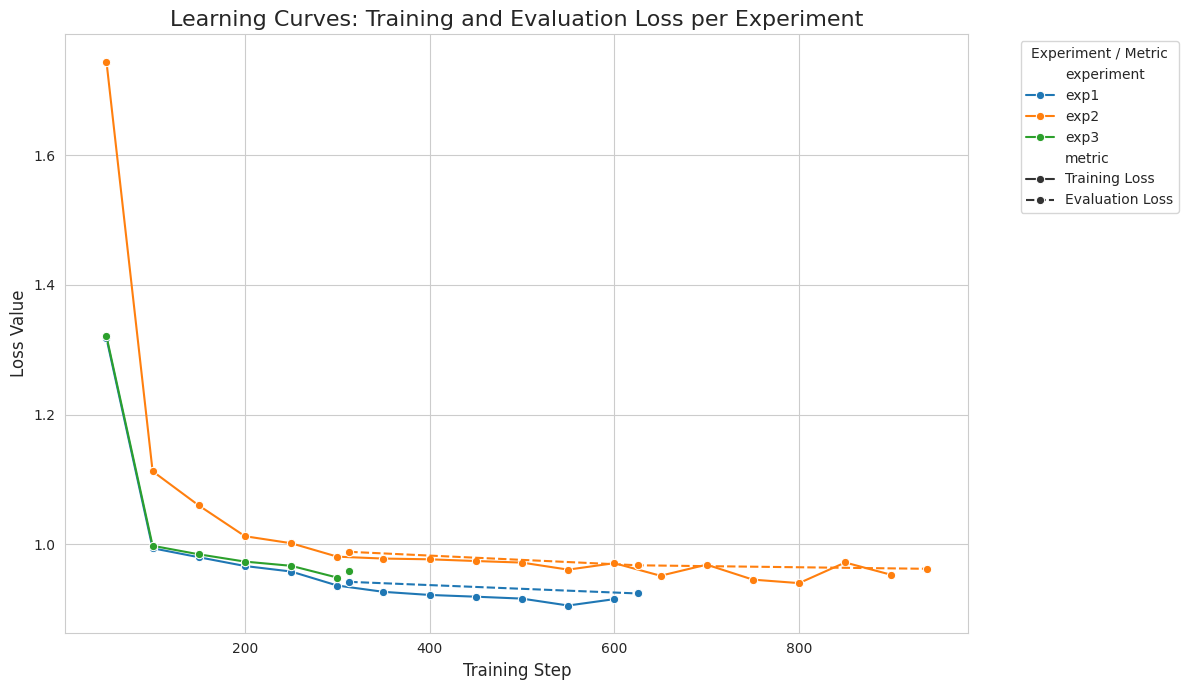

Learning curves plotted successfully, showing training and evaluation loss for each experiment.


In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for the plots
sns.set_style("whitegrid")

plt.figure(figsize=(12, 7))
sns.lineplot(data=plot_df, x="step", y="value", hue="experiment", style="metric", marker="o")

plt.title("Learning Curves: Training and Evaluation Loss per Experiment", fontsize=16)
plt.xlabel("Training Step", fontsize=12)
plt.ylabel("Loss Value", fontsize=12)
plt.legend(title="Experiment / Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Learning curves plotted successfully, showing training and evaluation loss for each experiment.")